In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import sys
print(sys.executable)

/cluster/home/9339yk/ml23_fmri_group_20a/venv/bin/python


In [4]:
!jupyter kernelspec list

Available kernels:
  python3    /cluster/home/9339yk/ml23_fmri_group_20a/venv/share/jupyter/kernels/python3


In [72]:
import glob
import random
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from skimage import color
from skimage import io
from skimage.transform import resize
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        print('enable gpu')
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

enable gpu
1 Physical GPUs, 1 Logical GPUs


2023-12-08 03:31:34.480192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 03:31:34.856183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 03:31:34.856279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
ROOT_FILE_PATH = "../REAL"
AREAS = ["prf-visualrois", "floc-bodies", "floc-faces", "floc-places", "floc-words", "streams", "all-vertices"]
MASK_KEYS = ["lh.fsaverage_space", "rh.fsaverage_space", "lh.space", "rh.space", "mapping"]

In [8]:
def ReadNpyFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    return_dic[filename] = np.load(path, allow_pickle = True)
  return return_dic

def ReadFmriFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    return_dic[filename[0]] = np.load(path, allow_pickle = True)
  return return_dic

def ReadMaskFile(dir_path):
  return_dic = {area: {} for area in AREAS}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    for area in AREAS:
      if area in filename:
        filename = "".join(i.strip("_") for i in filename.split(area))
        return_dic[area][filename] = np.load(path, allow_pickle = True) if filename[0] != "m" else np.load(path, allow_pickle = True).item()
        break
  return return_dic

def FetchPngFile(dir_path, index, mode = "rgb"):
  # img = iio.v3.imread()
  img = io.imread(os.path.join(dir_path, f'{index}.png'))
  if mode == "rgb":
    return img
  if mode == "hsv":
    return color.rgb2hsv(img)
    # return matplotlib.colors.rgb_to_hsv(img)
  if mode == "gray":
    return color.rgb2gray(img)
    # return np.dot(img, [0.299, 0.587, 0.114])
  

In [29]:
def ApplyRoiMask(roi, fmri, mask):
    hemisphere = ["l", "r"]
    # Define the ROI class based on the selected ROI
    if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
        roi_class = 'prf-visualrois'
    elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
        roi_class = 'floc-bodies'
    elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
        roi_class = 'floc-faces'
    elif roi in ["OPA", "PPA", "RSC"]:
        roi_class = 'floc-places'
    elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
        roi_class = 'floc-words'
    elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
        roi_class = 'streams'
    result = {}
    for items in hemisphere:
        _hfmri = fmri[items]
        roi_map = mask[roi_class]['mapping']
        challenge_roi_class = mask[roi_class][items+'h.space']
        roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
        challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
        result[items] = np.zeros(_hfmri.shape)
        result[items][:, np.where(challenge_roi)[0]] = _hfmri[:, np.where(challenge_roi)[0]]
    return result

In [9]:
def train_val_split(x, y, ratio, random_state=42):
  
  r = np.random.RandomState(random_state)
  
  idx = r.permutation(x.index)
  x_per = x.reindex(idx)
  y_per = y.reindex(idx)

  train_size = int(x.shape[0] * ratio)
  
  x_train = x_per[0:train_size]
  y_train = y_per[0:train_size]
  
  x_val = x_per[train_size:]
  y_val = y_per[train_size:]
  
  print('Training_dimension: ' + str(x_train.shape) + ' | ' + str(y_train.shape))
  print('Validation_dimension: ' + str(x_val.shape) + ' | ' + str(y_val.shape))

  return x_train, x_val, y_train, y_val

In [10]:
class ReadObject:
  
  #fmri = None           # dict(string -> ndarray, float32)
  #masks = None          # dict(string "AREA" -> (dict(int -> string), string "HEMISPHERE, " -> ndarray))
  
  #image_labels = None   # dataframe
  #label_names = None    # list

  subject = None        # string
  
  def __init__(self, subject):
    self.subject = subject

  # Mode = "train" | "test"
  def load(self, mode="train", load_images=True, image_mode="gray", image_count=-1):
    
    loaded_fmri = None
    loaded_images = None
    
    image_labels = pd.read_csv(os.path.join(ROOT_FILE_PATH, "image_infos", f"{self.subject}_infos_train.csv"))
    image_labels = image_labels.drop(image_labels.columns[[0, 1]], axis=1)
    
    label_names = image_labels.columns
    
    image_labels = image_labels.to_numpy(dtype=int)
    
    masks = ReadMaskFile(os.path.join(ROOT_FILE_PATH, self.subject , "roi_masks"))
    
    if load_images:
      image_count = image_labels.shape[0] if image_count is -1 else image_count
      print(f'Images: {image_count} | Labels: {image_labels.shape[1]} | Masks: {len(masks.keys())}')
    else:
      print(f'Labels: {image_labels.shape[1]} | Masks: {len(masks.keys())}')
        
    if mode == "train":
      loaded_fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "training_split", "training_fmri"))
      if load_images:
        
        print(f'Load {image_count} training images..')
        loaded_images = np.stack([
          FetchPngFile(os.path.join(ROOT_FILE_PATH, self.subject, "training_split", "training_images"), idx, mode = image_mode) for idx in range(image_count)
        ])
    elif mode == "test":
      loaded_fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "test_split", "test_fmri"))
            
    return label_names, image_labels, masks, loaded_fmri, loaded_images

  def split_data(self, image_labels, fmri, images, split_ratio=None, permutate=True, count=None, random_state=42):
    
    idx_train, idx_val = None, None
    images_train, images_val = None, None
    labels_val, fmri_l_val, fmri_r_val = None, None, None
    
    if split_ratio is None:
      split_ratio = 1
    
    random_state = np.random.RandomState(random_state)
    
    if count is not None and count > 0:
      fmri_l_train = fmri['l'][:count]
      fmri_r_train = fmri['r'][:count]
      labels_train = image_labels[:count]
      if images is not None:
        images_train = images[:count]
    else:
      fmri_l_train = fmri['l']
      fmri_r_train = fmri['r']
      labels_train = image_labels
      if images is not None:
          images_train = images
        
    if permutate:
      
        idx_train = random_state.permutation(labels_train.shape[0])
        
        fmri_l_train = fmri_l_train[idx_train]
        fmri_r_train = fmri_r_train[idx_train]
        labels_train = labels_train[idx_train]
        if images_train is not None:
          images_train = images_train[idx_train]
    
    if split_ratio < 1.0:
      
      train_size = int(labels_train.shape[0] * split_ratio)
      
      idx_val = idx_train[train_size:]
      fmri_l_val = fmri_l_train[train_size:]
      fmri_r_val = fmri_r_train[train_size:]
      labels_val = labels_train[train_size:]
      if images_train is not None:
        images_val = images_train[train_size:]
  
      idx_train = idx_train[0:train_size]
      fmri_l_train = fmri_l_train[0:train_size]
      fmri_r_train = fmri_r_train[0:train_size]
      labels_train = labels_train[0:train_size]
      if images_train is not None:
        images_train = images_train[0:train_size]
    
    return (labels_train, labels_val), (fmri_l_train, fmri_l_val), (fmri_r_train, fmri_r_val), (images_train, images_val), (idx_train, idx_val)

<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_953934/1701916160.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
  image_count = image_labels.shape[0] if image_count is -1 else image_count


In [11]:
SUBJ_LIST = ["subj01", "subj02",  "subj04", "subj05", "subj06", "subj07", "subj08"]#"subj03",

In [12]:
def min_max_normalize(data, min=0, max=1, dtype='float32'):
  
  # Define the original range
  old_min = np.min(data)
  old_max = np.max(data)
  
  # Map the values from the original range to the new range
  data = (np.array(data, dtype=dtype) - old_min) * (max - min) / (old_max - old_min) + min
  
  return data

In [13]:
%matplotlib inline
def showSingleImage(subject, index, image_mode='gray'):
  image = FetchPngFile(os.path.join(ROOT_FILE_PATH, subject, "training_split", "training_images"), index, mode=image_mode)
  plt.imshow(image, cmap='gray')
  plt.show()

### Load subject train / val data

In [100]:
global_labels_name = None
global_labels_train = None
global_labels_val = None
global_fmri_l_train = None
global_fmri_l_val = None
global_fmri_r_train = None
global_fmri_r_val = None
global_images_train = None
global_images_val = None
global_idx_train = None
global_idx_val = None

global_train_count = None
global_val_count = None

load_mode= 'train'
subject_count = 1

image_mode = "gray"
image_count = 3000 # -1 for all or 0 for none or > 2 for images
load_images = image_count > 0 and load_mode == 'train'

fit_fmri_dimension = True
fit_fmri_target_size = 21025 # 145 x 145

for sub in SUBJ_LIST[:subject_count]:
  
  print(sub)
  
  sub_obj = ReadObject(sub)
  label_names, image_labels, masks, fmri, images = sub_obj.load(mode=load_mode, load_images=load_images, image_count=image_count)
  
  fmri = ApplyRoiMask("V1v", fmri, masks)
  global_labels_name = label_names if global_labels_name is None else global_labels_name
  
  count = None if images is None else images.shape[0]
  split_ratio = 0.99 if load_mode == 'train' else 1
  
  ((labels_train, labels_val), (fmri_l_train, fmri_l_val), (fmri_r_train, fmri_r_val), (images_train, images_val), (idx_train, idx_val)) = (
    sub_obj.split_data(image_labels, fmri, images, split_ratio=split_ratio, count=count, permutate= load_mode=='train'))
  
  global_train_count = labels_train.shape[0] if global_train_count is None else global_train_count
  global_val_count = labels_val.shape[0] if global_val_count is None else global_val_count

  global_idx_train = idx_train if global_idx_train is None else np.concatenate((global_idx_train, idx_train))
  if idx_val is not None:
    global_idx_val = idx_val if global_idx_val is None else np.concatenate((global_idx_val, idx_val))
  
  print(f"labels_train  shape: {labels_train.shape}")
  global_labels_train = labels_train if global_labels_train is None else np.vstack((global_labels_train, labels_train))
  
  if labels_val is not None:
    print(f"labels_val  shape: {labels_val.shape}")
    global_labels_val = labels_val if global_labels_val is None else np.vstack((global_labels_val, labels_val))
  
  print(fmri_l_train.shape)
  if fit_fmri_dimension:
    additional_rows = np.zeros(shape=(fmri_l_train.shape[0], fit_fmri_target_size - fmri_l_train.shape[1]))
    fmri_l_train = np.concatenate((fmri_l_train, additional_rows), axis=1)
  fmri_l_train = min_max_normalize(fmri_l_train) # fmri_l_train / np.max(fmri_l_train)
  print(f"fmri_l_train  shape: {fmri_l_train.shape} | min: {np.min(fmri_l_train)} max: {np.max(fmri_l_train)}")
  global_fmri_l_train = fmri_l_train if global_fmri_l_train is None else np.vstack((global_fmri_l_train, fmri_l_train))
  
  if fmri_l_val is not None:
    if fit_fmri_dimension:
      additional_rows = np.zeros(shape=(fmri_l_val.shape[0], fit_fmri_target_size - fmri_l_val.shape[1]))
      fmri_l_val = np.concatenate((fmri_l_val, additional_rows), axis=1)
    fmri_l_val = min_max_normalize(fmri_l_val) # fmri_l_val / np.max(fmri_l_val)
    print(f"fmri_l_val  shape: {fmri_l_val.shape} | min: {np.min(fmri_l_val)} max: {np.max(fmri_l_val)}")
    global_fmri_l_val = fmri_l_val if global_fmri_l_val is None else np.vstack((global_fmri_l_val, fmri_l_val))
  
  if fit_fmri_dimension:
    additional_rows = np.zeros(shape=(fmri_r_train.shape[0], fit_fmri_target_size - fmri_r_train.shape[1]))
    fmri_r_train = np.concatenate((fmri_r_train, additional_rows), axis=1)
  fmri_r_train = min_max_normalize(fmri_r_train) # fmri_r_train / np.max(fmri_r_train)
  print(f"fmri_r_train  shape: {fmri_r_train.shape} | min: {np.min(fmri_r_train)} max: {np.max(fmri_r_train)}")
  global_fmri_r_train = fmri_r_train if global_fmri_r_train is None else np.vstack((global_fmri_r_train, fmri_r_train))
  
  if fmri_r_val is not None:
    if fit_fmri_dimension:
      additional_rows = np.zeros(shape=(fmri_r_val.shape[0], fit_fmri_target_size - fmri_r_val.shape[1]))
      fmri_r_val = np.concatenate((fmri_r_val, additional_rows), axis=1)
    fmri_r_val = min_max_normalize(fmri_r_val) # fmri_r_val / np.max(fmri_r_val)
    print(f"fmri_r_val  shape: {fmri_r_val.shape} | min: {np.min(fmri_r_val)} max: {np.max(fmri_r_val)}")
    global_fmri_r_val = fmri_r_val if global_fmri_r_val is None else np.vstack((global_fmri_r_val, fmri_r_val))
  
  if load_images:
  
    if image_mode == 'rgb':
      images_train = images_train / 255. 
    elif image_mode == 'gray':
      images_train = images_train.reshape((-1, images_train.shape[1], images_train.shape[2], 1))
        
    print(f"images_train  shape: {images_train.shape} | min: {np.min(images_train)} max: {np.max(images_train)}")
    global_images_train = images_train if global_images_train is None else np.vstack((global_images_train, images_train))
    
    if image_mode == 'rgb':
      images_val = images_val / 255. 
    elif image_mode == 'gray':
      images_val = images_val.reshape((-1, images_val.shape[1], images_val.shape[2], 1))
        
    print(f"images_val  shape: {images_val.shape} | min: {np.min(images_val)} max: {np.max(images_val)}")
    global_images_val = images_val if global_images_val is None else np.vstack((global_images_val, images_val))
  
  # Free memory
  labels_train, labels_val, fmri_l_train, fmri_l_val, fmri_r_train, fmri_r_val, images_train, images_val = None, None, None, None, None, None, None, None
  label_names, image_labels = None, None
  additional_rows = None
  
  print('')

subj01
Images: 3000 | Labels: 133 | Masks: 7
Load 3000 training images..
labels_train  shape: (2970, 133)
labels_val  shape: (30, 133)
(2970, 19004)
fmri_l_train  shape: (2970, 21025) | min: 0.0 max: 1.0
fmri_l_val  shape: (30, 21025) | min: 0.0 max: 1.0
fmri_r_train  shape: (2970, 21025) | min: 0.0 max: 1.0
fmri_r_val  shape: (30, 21025) | min: 0.0 max: 1.0
images_train  shape: (2970, 425, 425, 1) | min: 0.0 max: 1.0
images_val  shape: (30, 425, 425, 1) | min: 0.0 max: 1.0



In [101]:
print('Global train shapes:')
print(global_labels_train.shape)
print(global_labels_val.shape)
print(global_fmri_l_train.shape)
print(global_fmri_l_val.shape)
print(global_fmri_r_train.shape)
print(global_fmri_r_val.shape)
print(global_idx_train.shape)
print(global_idx_val.shape)

print(global_train_count)
print(global_val_count)

if load_images:
  print(global_images_train.shape)
  print(global_images_val.shape)

Global train shapes:
(2970, 133)
(30, 133)
(2970, 21025)
(30, 21025)
(2970, 21025)
(30, 21025)
(2970,)
(30,)
2970
30
(2970, 425, 425, 1)
(30, 425, 425, 1)


Global train labels:
{'person': 1503, 'bicycle': 78, 'car': 283, 'motorcycle': 76, 'airplane': 81, 'bus': 105, 'train': 111, 'truck': 130, 'boat': 76, 'traffic light': 93, 'fire hydrant': 40, 'stop sign': 41, 'parking meter': 15, 'bench': 133, 'bird': 98, 'cat': 128, 'dog': 108, 'horse': 63, 'sheep': 35, 'cow': 51, 'elephant': 68, 'bear': 25, 'zebra': 46, 'giraffe': 78, 'backpack': 119, 'umbrella': 80, 'handbag': 163, 'tie': 107, 'suitcase': 53, 'frisbee': 43, 'skis': 100, 'snowboard': 50, 'sports ball': 112, 'kite': 57, 'baseball bat': 53, 'baseball glove': 69, 'skateboard': 81, 'surfboard': 93, 'tennis racket': 98, 'bottle': 199, 'wine glass': 62, 'cup': 215, 'fork': 63, 'knife': 92, 'spoon': 97, 'bowl': 179, 'banana': 60, 'apple': 45, 'sandwich': 42, 'orange': 41, 'broccoli': 62, 'carrot': 57, 'hot dog': 27, 'pizza': 78, 'donut': 41, 'cake': 60, 'chair': 298, 'couch': 93, 'potted plant': 96, 'bed': 102, 'dining table': 279, 'toilet': 85, 'tv': 89, 'laptop': 67, 'mouse': 30, 'remote'

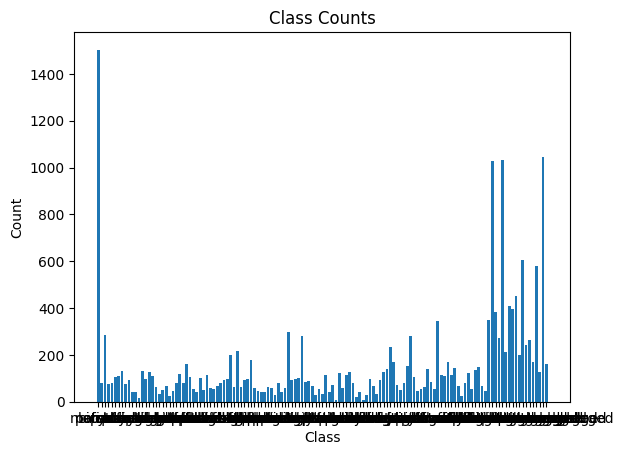

In [102]:
print(f'Global train labels:')
global_Y_train_classification = global_labels_train
count_categories = {}
for i in range(len(global_labels_name)):
    label_name = global_labels_name[i]
    label_column = global_Y_train_classification[:, i]
    count = np.sum(label_column)
    count_categories[label_name] = count
print(count_categories)

labels, counts = zip(*count_categories.items())
plt.bar(labels, counts)
plt.title('Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


### Load subject test data

In [16]:
# global_fmri_l_test = None
# global_fmri_r_test = None

# load_mode= 'test'
# subject_count = 3

# fit_fmri_dimension = True
# fit_fmri_target_size = 21025 # 145 x 145

# for sub in SUBJ_LIST[:subject_count]:
  
#   print(sub)
  
#   sub_obj = ReadObject(sub)
#   _, _, masks, fmri, _ = sub_obj.load(mode=load_mode, load_images=False)
  
#   ((_, _), (fmri_l_test, _), (fmri_r_test, _), (_, _), (_, _)) = (
#     sub_obj.split_data(_, fmri, None, split_ratio=1, count=None, permutate=False))
  
#   if fit_fmri_dimension:
#     additional_rows = np.zeros(shape=(fmri_l_test.shape[0], fit_fmri_target_size - fmri_l_test.shape[1]))
#     fmri_l_test = np.concatenate((fmri_l_test, additional_rows), axis=1)
#   fmri_l_test = min_max_normalize(fmri_l_test) # fmri_l_train / np.max(fmri_l_train)
#   print(f"fmri_l_test  shape: {fmri_l_test.shape} | min: {np.min(fmri_l_test)} max: {np.max(fmri_l_test)}")
#   global_fmri_l_test = fmri_l_test if global_fmri_l_train is None else np.vstack((global_fmri_l_train, fmri_l_test))
  
#   if fit_fmri_dimension:
#     additional_rows = np.zeros(shape=(fmri_r_test.shape[0], fit_fmri_target_size - fmri_r_test.shape[1]))
#     fmri_r_test = np.concatenate((fmri_r_test, additional_rows), axis=1)
#   fmri_r_test = min_max_normalize(fmri_r_test) # fmri_r_train / np.max(fmri_r_train)
#   print(f"fmri_r_test  shape: {fmri_r_test.shape} | min: {np.min(fmri_r_test)} max: {np.max(fmri_r_test)}")
#   global_fmri_r_test = fmri_r_test if global_fmri_r_train is None else np.vstack((global_fmri_r_train, fmri_r_test))
  
#   # Free memory
#   fmri_l_train, fmri_r_train = None, None
#   masks, fmri = None, None
#   additional_rows = None
  
#   print('')

In [17]:
# print('Global test shapes:')
# print(global_fmri_l_test.shape)
# print(global_fmri_r_test.shape)

### Visualisation

In [103]:
%matplotlib inline
def visualise_data(label_names, labels, image, fmri_l, fmri_r):
  if label_names is not None and labels is not None:
    labels = np.array(label_names)[np.where(labels != 0)] 
    print(labels)
  if image is not None:
    print(image.shape)
    plt.imshow(image, cmap='gray')
    plt.show()
  if fmri_l is not None:
    print(fmri_l.shape)
    plt.imshow(fmri_l.reshape(145, 145, 1), cmap='gray')
    plt.show()
  if fmri_r is not None:
    print(fmri_r.shape)
    plt.imshow(fmri_r.reshape(145, 145, 1), cmap='gray')
    plt.show()

### Test loaded training data

Label test of training data 1849:
['person' 'car' 'truck' 'kite' 'tree-merged' 'sky-other-merged'
 'grass-merged']
(425, 425, 1)


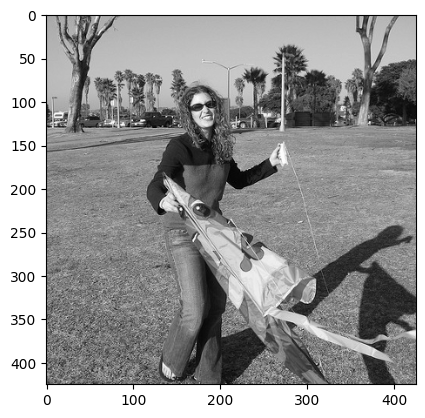

(21025,)


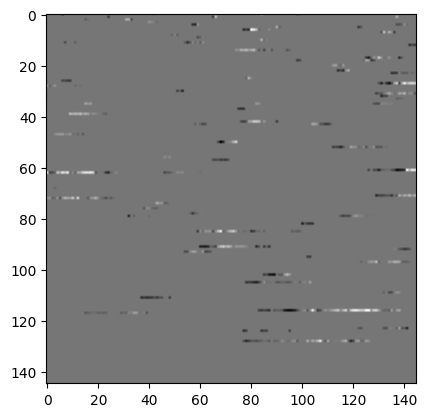

(21025,)


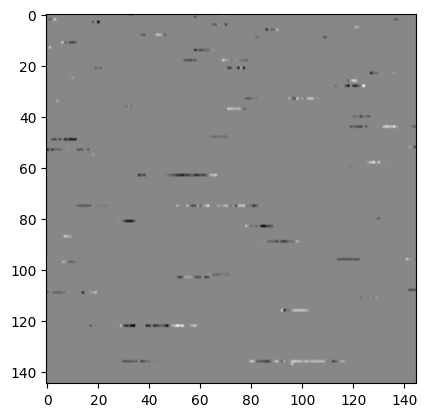

In [104]:
label_test_training_index = random.randint(0, global_labels_train.shape[0] - 1)
print(f'Label test of training data {label_test_training_index}:')
if load_images:
  visualise_data(global_labels_name, global_labels_train[label_test_training_index], global_images_train[label_test_training_index], global_fmri_l_train[label_test_training_index], global_fmri_r_train[label_test_training_index])
else:
    visualise_data(global_labels_name, global_labels_train[label_test_training_index], None, global_fmri_l_train[label_test_training_index], global_fmri_r_train[label_test_training_index])

In [105]:
from tensorflow import keras

### Image classification 1D

In [106]:
#### Preprocess fmri for 1D

In [107]:
print(f'Combine fmri data train (1D):')

global_X_train_1D = np.stack([global_fmri_l_train, global_fmri_r_train], axis=-1)
print(global_X_train_1D.shape)

print(f'\nCombine fmri data val (1D):')

global_X_val_1D = np.stack([global_fmri_l_val, global_fmri_r_val], axis=-1)
print(global_X_val_1D.shape)

Combine fmri data train (1D):
(2970, 21025, 2)

Combine fmri data val (1D):
(30, 21025, 2)


## Model for 1D

In [75]:
model1D = keras.models.Sequential()

model1D.add(keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, input_shape=(21025, 2)))
model1D.add(keras.layers.BatchNormalization())
model1D.add(keras.layers.LeakyReLU())
model1D.add(keras.layers.Conv1D(filters=32, kernel_size=3, strides=2))
model1D.add(keras.layers.BatchNormalization())
model1D.add(keras.layers.LeakyReLU())

model1D.add(keras.layers.Conv1D(filters=64, kernel_size=3))
model1D.add(keras.layers.BatchNormalization())
model1D.add(keras.layers.LeakyReLU())
model1D.add(keras.layers.Conv1D(filters=64, kernel_size=3))
model1D.add(keras.layers.BatchNormalization())
model1D.add(keras.layers.LeakyReLU())

model1D.add(keras.layers.Conv1D(filters=128, kernel_size=3))
model1D.add(keras.layers.BatchNormalization())
model1D.add(keras.layers.LeakyReLU())
model1D.add(keras.layers.Conv1D(filters=128, kernel_size=3))
model1D.add(keras.layers.BatchNormalization())
model1D.add(keras.layers.LeakyReLU())

model1D.add(keras.layers.Flatten())

model1D.add(keras.layers.Dense(256, activation="relu"))
model1D.add(keras.layers.Dense(256, activation="relu"))
model1D.add(keras.layers.Dense(133, activation="softmax"))

model1D.summary()

model1D.compile(
  optimizer= keras.optimizers.SGD(learning_rate=0.00000001), loss= keras.losses.CategoricalCrossentropy(), metrics= [keras.metrics.CategoricalAccuracy()]) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 10512, 32)         224       
                                                                 
 batch_normalization_12 (Ba  (None, 10512, 32)         128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 10512, 32)         0         
                                                                 
 conv1d_13 (Conv1D)          (None, 5255, 32)          3104      
                                                                 
 batch_normalization_13 (Ba  (None, 5255, 32)          128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 5255, 32)         

In [78]:
checkpoint_path = "best_model.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_best_only=True,
                                      monitor='val_categorical_accuracy',  
                                      mode='max', 
                                      verbose=1)

In [70]:
with tf.device('/cpu:0'):
   global_X_train_1D_tf = tf.convert_to_tensor(global_X_train_1D, np.float32)
   global_labels_traintf = tf.convert_to_tensor(global_labels_train, np.float32)

## Training: subj 1~8 excludes 4

In [79]:
history1D = None
history1D = model1D.fit(global_X_train_1D_tf, global_labels_traintf, validation_data=(global_X_val_1D, global_labels_val), batch_size=64, epochs=20, callbacks=[checkpoint_callback])

Epoch 1/20


541/542 [============================>.] - ETA: 0s - loss: 33.8621 - categorical_accuracy: 0.0013
Epoch 1: val_categorical_accuracy improved from -inf to 0.00286, saving model to best_model.h5


/cluster/home/9339yk/ml23_fmri_group_20a/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


542/542 [==============================] - 45s 82ms/step - loss: 33.8652 - categorical_accuracy: 0.0013 - val_loss: 36.7109 - val_categorical_accuracy: 0.0029
Epoch 2/20
541/542 [============================>.] - ETA: 0s - loss: 33.8310 - categorical_accuracy: 0.0013
Epoch 2: val_categorical_accuracy did not improve from 0.00286
542/542 [==============================] - 31s 58ms/step - loss: 33.8310 - categorical_accuracy: 0.0013 - val_loss: 44.4260 - val_categorical_accuracy: 0.0029
Epoch 3/20
541/542 [============================>.] - ETA: 0s - loss: 33.7960 - categorical_accuracy: 0.0014
Epoch 3: val_categorical_accuracy did not improve from 0.00286
542/542 [==============================] - 31s 58ms/step - loss: 33.7951 - categorical_accuracy: 0.0014 - val_loss: 44.1965 - val_categorical_accuracy: 0.0029
Epoch 4/20
541/542 [============================>.] - ETA: 0s - loss: 33.7666 - categorical_accuracy: 0.0011
Epoch 4: val_categorical_accuracy did not improve from 0.00286
542/542

In [80]:
if history1D:
  
  # Accessing training history
  training_loss = history1D.history['loss']
  training_accuracy = history1D.history['categorical_accuracy']
  validation_loss = history1D.history['val_loss']
  validation_accuracy = history1D.history['val_categorical_accuracy']
  
  # Printing training and validation loss and accuracy
  for i in range(len(training_loss)):
      print(f"Epoch {i+1}: "
            f"Training Loss: {training_loss[i]}, "
            f"Training Accuracy: {training_accuracy[i]}, "
            f"Validation Loss: {validation_loss[i]}, "
            f"Validation Accuracy: {validation_accuracy[i]}"
            )

Epoch 1: Training Loss: 33.865234375, Training Accuracy: 0.0013275613309815526, Validation Loss: 36.71088409423828, Validation Accuracy: 0.0028571428265422583
Epoch 2: Training Loss: 33.830997467041016, Training Accuracy: 0.0012987012742087245, Validation Loss: 44.42598342895508, Validation Accuracy: 0.0028571428265422583
Epoch 3: Training Loss: 33.79507064819336, Training Accuracy: 0.001385281328111887, Validation Loss: 44.196533203125, Validation Accuracy: 0.0028571428265422583
Epoch 4: Training Loss: 33.7642936706543, Training Accuracy: 0.0010966811096295714, Validation Loss: 44.05453109741211, Validation Accuracy: 0.0028571428265422583
Epoch 5: Training Loss: 33.733455657958984, Training Accuracy: 0.0013275613309815526, Validation Loss: 44.03363800048828, Validation Accuracy: 0.0028571428265422583
Epoch 6: Training Loss: 33.69977951049805, Training Accuracy: 0.0012409812770783901, Validation Loss: 43.79771041870117, Validation Accuracy: 0.0028571428265422583
Epoch 7: Training Loss:

In [ ]:
# loaded_classification_model1D = keras.models.load_model('models/best_model1D.h5')

## Prediction 


In [81]:
prediction_model = model1D.predict(global_X_val_1D)
print(prediction_model.shape)

11/11 [==============================] - 0s 6ms/step
(350, 133)


In [86]:
prediction_model1D_index = random.randint(0, prediction_model.shape[0] - 1)
if load_images:
  visualise_data(global_labels_name, global_labels_val[prediction_model1D_index], global_images_val[prediction_model1D_index], None, None)
else:
  visualise_data(global_labels_name, global_labels_val[prediction_model1D_index], None, None, None)

['person' 'bicycle' 'car' 'bench' 'frisbee' 'door-stuff' 'house' 'light'
 'roof' 'wall-brick' 'window-other' 'tree-merged' 'sky-other-merged'
 'pavement-merged' 'grass-merged' 'dirt-merged' 'building-other-merged'
 'rock-merged' 'wall-other-merged']


1


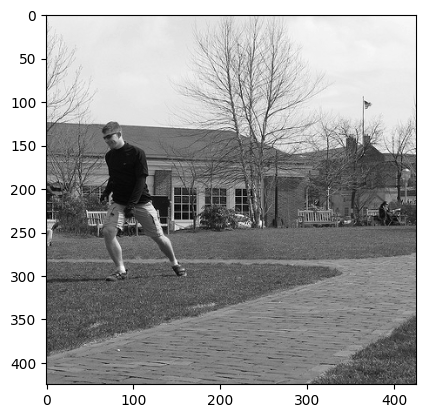

In [87]:
import math
sub_index = math.floor(prediction_model1D_index / global_val_count)
print(sub_index)
showSingleImage(SUBJ_LIST[sub_index], global_idx_val[prediction_model1D_index])

In [88]:
label_count = 3
# print(prediction_model[prediction_model1D_index])
top_3_indices = np.argsort(prediction_model[prediction_model1D_index])[-label_count:][::-1]
top_3_values = prediction_model[prediction_model1D_index][top_3_indices]
print(f"Top 3 indices: {top_3_indices} | Top 3 values: {top_3_values}")
print("Top 3 labels:", global_labels_name[top_3_indices])

Top 3 indices: [33 82 85] | Top 3 values: [0.34375915 0.07250788 0.05207446]
Top 3 labels: Index(['kite', 'bridge', 'curtain'], dtype='object')


## Image classification 2D

#### Preprocess fmri for 2D

In [109]:
print(f'Combine fmri data train (2D):')

global_X_train_2D = np.stack([global_fmri_l_train, global_fmri_r_train], axis=-1)
global_X_train_2D = global_X_train_2D.reshape(-1, 145, 145, 2)
print(global_X_train_2D.shape)

print(f'\nCombine fmri data val (2D):')

global_X_val_2D = np.stack([global_fmri_l_val, global_fmri_r_val], axis=-1)
global_X_val_2D = global_X_val_2D.reshape(-1, 145, 145, 2)
print(global_X_val_2D.shape)

Combine fmri data train (2D):
(2970, 145, 145, 2)

Combine fmri data val (2D):
(30, 145, 145, 2)


## Model for 2D

In [110]:
model2D = keras.models.Sequential()

model2D.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", strides=2, input_shape=(145, 145, 2)))
model2D.add(keras.layers.BatchNormalization())
model2D.add(keras.layers.LeakyReLU())
model2D.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", strides=2))
model2D.add(keras.layers.BatchNormalization())
model2D.add(keras.layers.LeakyReLU())
#model2D.add(keras.layers.MaxPool2D())

model2D.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
model2D.add(keras.layers.BatchNormalization())
model2D.add(keras.layers.LeakyReLU())
model2D.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
model2D.add(keras.layers.BatchNormalization())
model2D.add(keras.layers.LeakyReLU())
#model2D.add(keras.layers.MaxPool2D())

model2D.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
model2D.add(keras.layers.BatchNormalization())
model2D.add(keras.layers.LeakyReLU())
model2D.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
model2D.add(keras.layers.BatchNormalization())
model2D.add(keras.layers.LeakyReLU())
#model2D.add(keras.layers.MaxPool2D())

model2D.add(keras.layers.Flatten())

model2D.add(keras.layers.Dense(256, activation="relu"))
model2D.add(keras.layers.Dense(256, activation="relu"))
model2D.add(keras.layers.Dense(133, activation="softmax"))

model2D.compile(
  optimizer= keras.optimizers.SGD(learning_rate=0.000001), loss= keras.losses.CategoricalCrossentropy(), metrics= [keras.metrics.CategoricalAccuracy()]
) 

model2D.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        608       
                                                                 
 batch_normalization_18 (Ba  (None, 73, 73, 32)        128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 73, 73, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        9248      
                                                                 
 batch_normalization_19 (Ba  (None, 37, 37, 32)        128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 37, 37, 32)       

## Training(2D)

In [111]:
history2D = None
history2D = model2D.fit(global_X_train_2D, global_labels_train, validation_data=(global_X_val_2D, global_labels_val), batch_size=64, epochs=20)

Epoch 1/20
47/47 [==============================] - 4s 28ms/step - loss: 34.1715 - categorical_accuracy: 0.0013 - val_loss: 33.7494 - val_categorical_accuracy: 0.0000e+00
Epoch 2/20
47/47 [==============================] - 1s 13ms/step - loss: 33.6821 - categorical_accuracy: 0.0027 - val_loss: 33.7596 - val_categorical_accuracy: 0.0000e+00
Epoch 3/20
47/47 [==============================] - 1s 13ms/step - loss: 33.3312 - categorical_accuracy: 0.0088 - val_loss: 33.7536 - val_categorical_accuracy: 0.0000e+00
Epoch 4/20
47/47 [==============================] - 1s 13ms/step - loss: 33.0776 - categorical_accuracy: 0.0222 - val_loss: 33.7311 - val_categorical_accuracy: 0.0000e+00
Epoch 5/20
47/47 [==============================] - 1s 13ms/step - loss: 32.9150 - categorical_accuracy: 0.0438 - val_loss: 33.7310 - val_categorical_accuracy: 0.0000e+00
Epoch 6/20
47/47 [==============================] - 1s 13ms/step - loss: 32.8306 - categorical_accuracy: 0.0643 - val_loss: 33.6483 - val_categor

In [ ]:
keras.models.save_model(model2D, 'models/classification_model2D.h5')

In [ ]:
loaded_classification_model2D = keras.models.load_model('models/classification_model2D.h5')

In [113]:
prediction_model = model2D.predict(global_X_val_2D)
print(prediction_model.shape)

1/1 [==============================] - 0s 55ms/step
(30, 133)


['stop sign' 'house' 'tree-merged']
(425, 425, 1)


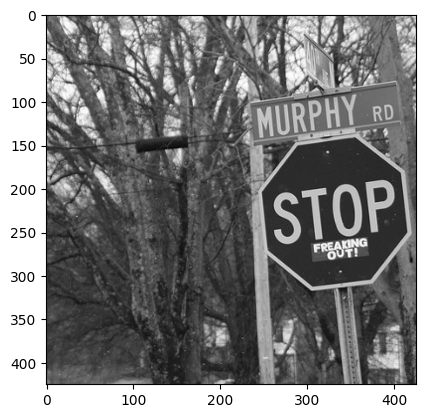

In [114]:
prediction_model2D_index = random.randint(0, prediction_model.shape[0] - 1)
if load_images:
  visualise_data(global_labels_name, global_labels_val[prediction_model2D_index], global_images_val[prediction_model2D_index], None, None)
else:
  visualise_data(global_labels_name, global_labels_val[prediction_model2D_index], None, None, None)

In [118]:
label_count = 5
# print(prediction_model[prediction_model2D_index])
top_3_indices = np.argsort(prediction_model[prediction_model2D_index])[-label_count:][::-1]
top_3_values = prediction_model[prediction_model2D_index][top_3_indices]
print(f"Top 3 indices: {top_3_indices} | Top 3 values: {top_3_values}")
print("Top 3 labels:", global_labels_name[top_3_indices])

Top 3 indices: [116 125 124   0 101] | Top 3 values: [0.24011926 0.13799512 0.11484624 0.08758865 0.08126705]
Top 3 labels: Index(['tree-merged', 'grass-merged', 'mountain-merged', 'person', 'roof'], dtype='object')


# Image reconstruction 1

In [122]:
## Resize images
size = 288
count = 2970
resized_288_Y_train_images = np.zeros((count, size, size, global_images_train.shape[3]))
for index in range(count):
  if index % 1000 == 0:
    print(index)
  resized_288_Y_train_images[index] = resize(global_images_train[index], (size, size, global_images_train.shape[3]), anti_aliasing=True)
print(resized_288_Y_train_images.shape)

0


1000
2000
(2970, 288, 288, 1)


In [123]:
encoder1 = keras.models.Sequential()

encoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(145, 145, 2)))
encoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

encoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

encoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
encoder1.summary()

decoder1 = keras.models.Sequential()

decoder1.add(keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(18, 18, 128)))
decoder1.add(keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(4, 4)))

decoder1.add(keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(2, 2)))

decoder1.add(keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(2, 2)))

decoder1.add(keras.layers.Conv2DTranspose(resized_288_Y_train_images.shape[3], kernel_size=(3, 3), padding="same", activation='sigmoid'))
decoder1.summary()

model1 = keras.models.Sequential()
model1.add(encoder1)
model1.add(decoder1)

model1.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.BinaryCrossentropy())
#model1.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.MSE())
#model1.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss='mae')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 145, 145, 32)      608       
                                                                 


 conv2d_13 (Conv2D)          (None, 145, 145, 32)      9248      
                                                                 
 batch_normalization_30 (Ba  (None, 145, 145, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 72, 72, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 batch_normalization_31 (Ba  (None, 72, 72, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooli

## Image reconstruction 1 Training: subj01[:3000]

In [124]:
model1.fit(global_X_train_2D[:count], resized_288_Y_train_images, batch_size=32, epochs=10)

Epoch 1/10


2023-12-08 05:06:06.254095: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-08 05:06:06.435922: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-08 05:06:06.502246: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-08 05:06:06.566189: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


93/93 [==============================] - 9s 45ms/step - loss: 0.8547
Epoch 2/10
93/93 [==============================] - 3s 31ms/step - loss: 0.8356
Epoch 3/10
93/93 [==============================] - 3s 30ms/step - loss: 0.8194
Epoch 4/10
93/93 [==============================] - 3s 30ms/step - loss: 0.8071
Epoch 5/10
93/93 [==============================] - 3s 31ms/step - loss: 0.7978
Epoch 6/10
93/93 [==============================] - 3s 30ms/step - loss: 0.7901
Epoch 7/10
93/93 [==============================] - 3s 30ms/step - loss: 0.7835
Epoch 8/10
93/93 [==============================] - 3s 30ms/step - loss: 0.7779
Epoch 9/10
93/93 [==============================] - 3s 30ms/step - loss: 0.7728
Epoch 10/10
93/93 [==============================] - 3s 30ms/step - loss: 0.7683


In [ ]:
keras.models.save_model(model1, 'models/reconstruction_model1.h5')

In [ ]:
loaded_reconstruction_model1 = keras.models.load_model('models/reconstruction_model1.h5')

In [125]:
prediction_model1 = model1.predict(global_X_val_2D)
print(prediction_model1.shape)

1/1 [==============================] - 1s 532ms/step
(30, 288, 288, 1)


2023-12-08 05:06:45.484493: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


['sheep' 'road' 'tree-merged' 'grass-merged']
(425, 425, 1)


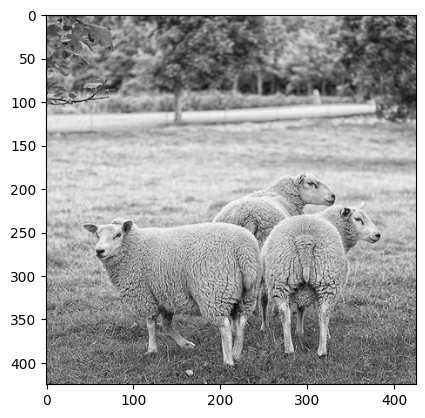

['sheep' 'road' 'tree-merged' 'grass-merged']
(288, 288, 1)


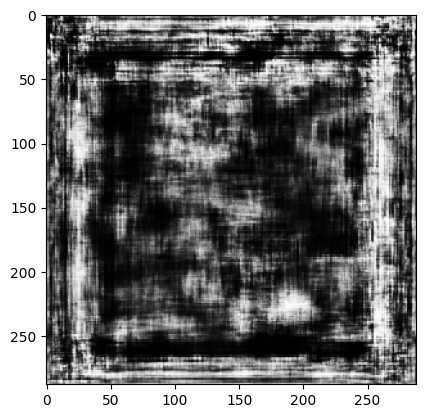

In [126]:
prediction_model1_index = random.randint(0, prediction_model1.shape[0] - 1)
visualise_data(global_labels_name, global_labels_val[prediction_model1_index], global_images_val[prediction_model1_index], None, None)
visualise_data(global_labels_name, global_labels_val[prediction_model1_index], prediction_model1[prediction_model1_index], None, None)

# Image reconstruction 2

In [128]:
## Resize images
size = 230
count = 2950
resized_230_Y_train_images = np.zeros((count, size, size, global_images_train.shape[3]))
for index in range(count):
  if index % 300 == 0:
    print(index)
  resized_230_Y_train_images[index] = resize(global_images_train[index], (size, size, global_images_train.shape[3]), anti_aliasing=True)
print(resized_230_Y_train_images.shape)

0
300
600
900
1200
1500
1800
2100
2400
2700
(2950, 230, 230, 1)


In [129]:
encoder2 = keras.models.Sequential()

encoder2.add(keras.layers.Conv2D(32, kernel_size=4, strides=2, input_shape=(145, 145, 2)))
encoder2.add(keras.layers.Conv2D(32, kernel_size=4, strides=2))
encoder2.add(keras.layers.BatchNormalization())
encoder2.add(keras.layers.LeakyReLU())
encoder2.add(keras.layers.Dropout(0.1))

encoder2.add(keras.layers.Conv2D(64, kernel_size=3, strides=2))
encoder2.add(keras.layers.Conv2D(64, kernel_size=3, strides=2))
encoder2.add(keras.layers.BatchNormalization())
encoder2.add(keras.layers.LeakyReLU())
encoder2.add(keras.layers.Dropout(0.1))
encoder2.summary()

bridge2 = keras.models.Sequential()

bridge2.add(keras.layers.Conv2D(128, kernel_size=2, strides=2, input_shape=(7, 7, 64)))
bridge2.add(keras.layers.Conv2DTranspose(128, kernel_size=2, strides=2))
bridge2.summary()

decoder2 = keras.models.Sequential()

decoder2.add(keras.layers.BatchNormalization(input_shape=(6, 6, 128)))
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2))
decoder2.add(keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2))
decoder2.add(keras.layers.BatchNormalization())
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(32, kernel_size=4, strides=2))
decoder2.add(keras.layers.Conv2DTranspose(32, kernel_size=4, strides=2))
decoder2.add(keras.layers.BatchNormalization())
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(resized_230_Y_train_images.shape[3], kernel_size=4, strides=2))

decoder2.summary()

model2 = keras.models.Sequential()

model2.add(encoder2)
model2.add(bridge2)
model2.add(decoder2)

model2.summary()

#model2.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.BinaryCrossentropy())
model2.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss='mse')
#model2.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0001), loss='mae')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 71, 71, 32)        1056      
                                                                 
 conv2d_19 (Conv2D)          (None, 34, 34, 32)        16416     
                                                                 
 batch_normalization_36 (Ba  (None, 34, 34, 32)        128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 34, 34, 32)        0         
                                                                 
 dropout (Dropout)           (None, 34, 34, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 64)        18496     
                                                     

In [130]:
model2.fit(global_X_train_2D[:count], resized_230_Y_train_images, batch_size=64, epochs=60)

Epoch 1/60


2023-12-08 05:12:59.060308: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_13/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-08 05:12:59.387805: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-08 05:12:59.387832: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-08 05:12:59.387843: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-08 05:12:59.387853: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed t

47/47 [==============================] - 3s 24ms/step - loss: 0.5207
Epoch 2/60
47/47 [==============================] - 1s 14ms/step - loss: 0.5078
Epoch 3/60
47/47 [==============================] - 1s 14ms/step - loss: 0.4957
Epoch 4/60
47/47 [==============================] - 1s 14ms/step - loss: 0.4842
Epoch 5/60
47/47 [==============================] - 1s 14ms/step - loss: 0.4732
Epoch 6/60
47/47 [==============================] - 1s 14ms/step - loss: 0.4629
Epoch 7/60
47/47 [==============================] - 1s 14ms/step - loss: 0.4532
Epoch 8/60
47/47 [==============================] - 1s 14ms/step - loss: 0.4439
Epoch 9/60
47/47 [==============================] - 1s 14ms/step - loss: 0.4353
Epoch 10/60
47/47 [==============================] - 1s 14ms/step - loss: 0.4270
Epoch 11/60
47/47 [==============================] - 1s 14ms/step - loss: 0.4194
Epoch 12/60
47/47 [==============================] - 1s 14ms/step - loss: 0.4120
Epoch 13/60
47/47 [=============================

In [ ]:
# keras.models.save_model(model2, 'models/reconstruction_model2.h5')

In [ ]:
# loaded_reconstruction_model2 = keras.models.load_model('models/reconstruction_model2.h5')

In [131]:
prediction_model2 = model2.predict(global_X_val_2D)
print(prediction_model2.shape)

1/1 [==============================] - 0s 280ms/step
(30, 230, 230, 1)


['giraffe' 'tree-merged' 'sky-other-merged']
(425, 425, 1)


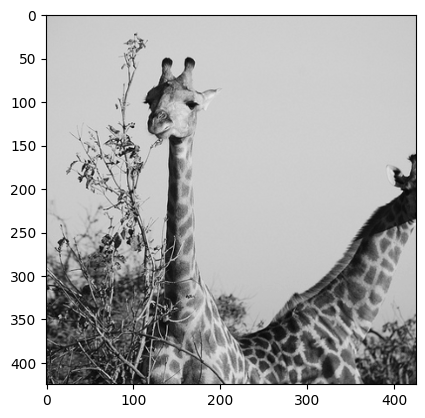

['giraffe' 'tree-merged' 'sky-other-merged']
(230, 230, 1)


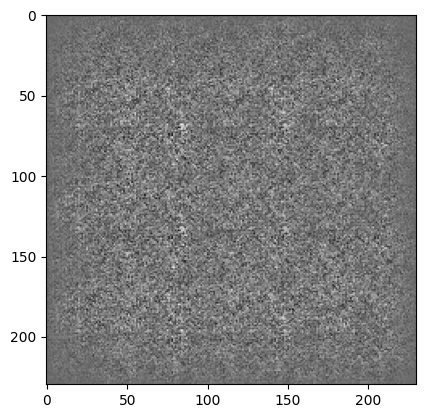

In [132]:
prediction_model2_index = random.randint(0, prediction_model2.shape[0] - 1)
visualise_data(global_labels_name, global_labels_val[prediction_model2_index], global_images_val[prediction_model2_index], None, None)
visualise_data(global_labels_name, global_labels_val[prediction_model2_index], prediction_model2[prediction_model2_index], None, None)